# Creating an example of a circuit cost function

In [1]:
from qiskit.circuit import QuantumCircuit
from qiskit import execute, BasicAer, Aer
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_distribution
from random import randrange
from numpy import pi
from project.unified_noise_model.Unified_Noise_Model import Unified_Noise_Model
import numpy as np
from scipy.optimize import minimize

In [291]:
def get_cost(key):
    z = np.array(list(key), dtype=int)
    if key == '0000':
        cost = np.sum(z)  
    else:
        cost = np.sum(z) + 10
    return cost

In [292]:
def quantum_circuit(param, num_qubits,num_iterations):
    qc = QuantumCircuit(num_qubits,num_qubits)
    
    for itr in range(num_iterations):
        for q in range(num_qubits):
            qc.rz(param[itr],q)
            qc.rz(param[itr+ num_iterations],q)
            qc.ry(param[itr+ 2*num_iterations],q)
            qc.ry(param[itr+ 3*num_iterations],q)
            #qc.rx(param[itr+ 4*num_iterations],q)
            #qc.rx(param[itr+ 5*num_iterations],q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    return qc

In [293]:
def get_avg_cost(circuit, num_qubits, noise_model):
    
    shots=4000
    
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(circuit,shots=shots).result()
    counts = result.get_counts(0)

    avg_cost = sum(counts[key] * get_cost(key) for key in counts)
    
    avg_cost = avg_cost / sum(counts.values()) 

    #costs.append(avg_cost )
    
    return avg_cost

In [294]:
def func(param, *args):
    num_qubits = args[0][0]
    num_iterations = args[0][1]
    noise_model = args[0][2]
    circuit = quantum_circuit(param,num_qubits,num_iterations)
    cost = get_avg_cost(circuit, num_qubits, noise_model)

    return cost

In [295]:
def cost_func_test_param(param, num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=4000

    for itr in range(num_iterations):
        for q in range(num_qubits):
            qc.rz(param[itr],q)
            qc.rz(param[itr+ num_iterations],q)
            qc.ry(param[itr+ 2*num_iterations],q)
            qc.ry(param[itr+ 3*num_iterations],q)
            #qc.rx(param[itr+ 4*num_iterations],q)
            #qc.rx(param[itr+ 5*num_iterations],q)
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Run the circuit 10000 times and store the results
    simulator = AerSimulator(noise_model=noise_model)
    result = simulator.run(qc,shots=shots).result()
    counts = result.get_counts(0)
    display(plot_distribution(counts,title = 'Optimize Results',figsize=[18,7]))
    
    avg_cost = sum(counts[key] * get_cost(key) for key in counts)
    avg_cost = avg_cost / sum(counts.values()) 
    print(avg_cost)
    return avg_cost

In [296]:
def cost_func_random(num_qubits,num_iterations,noise_model):
    qc = QuantumCircuit(num_qubits,num_qubits)
    shots=4000
    
    for itr in range(num_iterations):
        random_phi1 = np.random.uniform(0, 1)
        random_phi2 = np.random.uniform(0, 1)
        random_phi3 = np.random.uniform(0, 1)
        for q in range(num_qubits):
            qc.rz(random_phi1*pi,q)
            qc.rz(-random_phi1*pi,q)
            qc.ry(random_phi2*pi,q)
            qc.ry(-random_phi2*pi,q)
            #qc.rx(random_phi3*pi,q)
            #qc.rx(-random_phi3*pi,q)
            
    qc.measure(range(num_qubits),range(num_qubits))
    display(qc.draw('mpl'))
    
    #Noiseless 
    job = execute (qc,Aer.get_backend('qasm_simulator'),shots=shots)
    job_result = job.result()
    counts_noiseless = job_result.get_counts(qc)
    display(plot_distribution(counts_noiseless,title='Noiseless Results' ,figsize=[18,7]))
    
    simulator_noise = AerSimulator(noise_model=noise_model)
    result_noise = simulator_noise.run(qc,shots=shots).result()
    counts_noise = result_noise.get_counts(0)
    display(plot_distribution(counts_noise,title='Noisy Results' ,figsize=[18,7]))
    
    avg_cost = sum(counts_noise[key] * get_cost(key) for key in counts_noise)
    avg_cost = avg_cost / sum(counts_noise.values()) 
    #print(avg_cost)
    
    return avg_cost

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


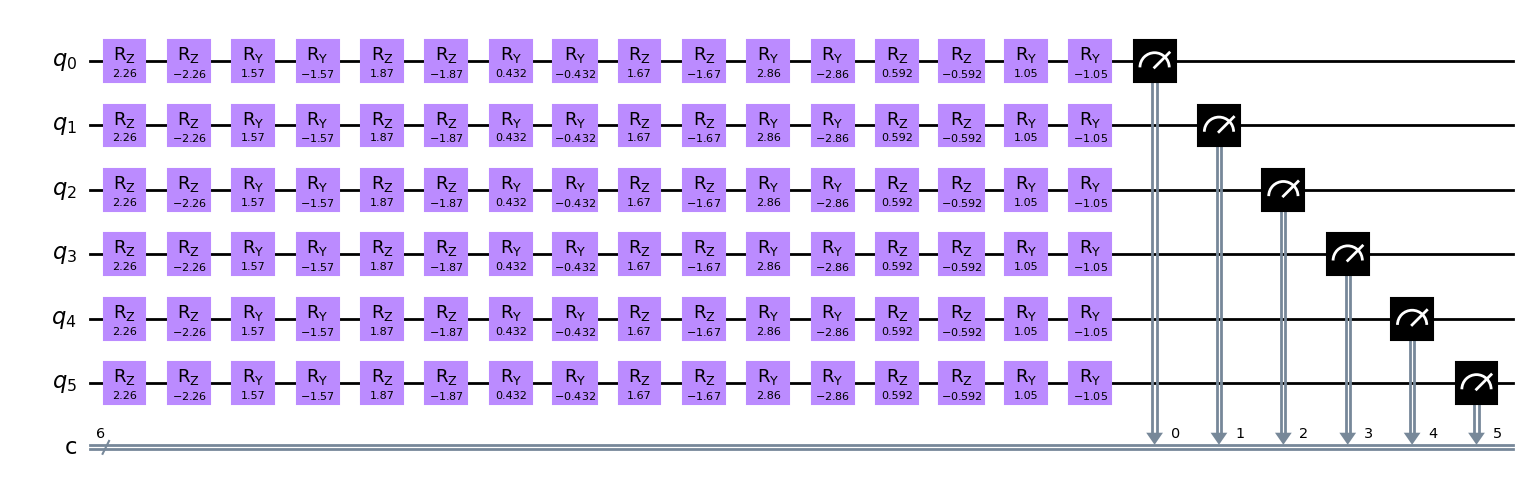

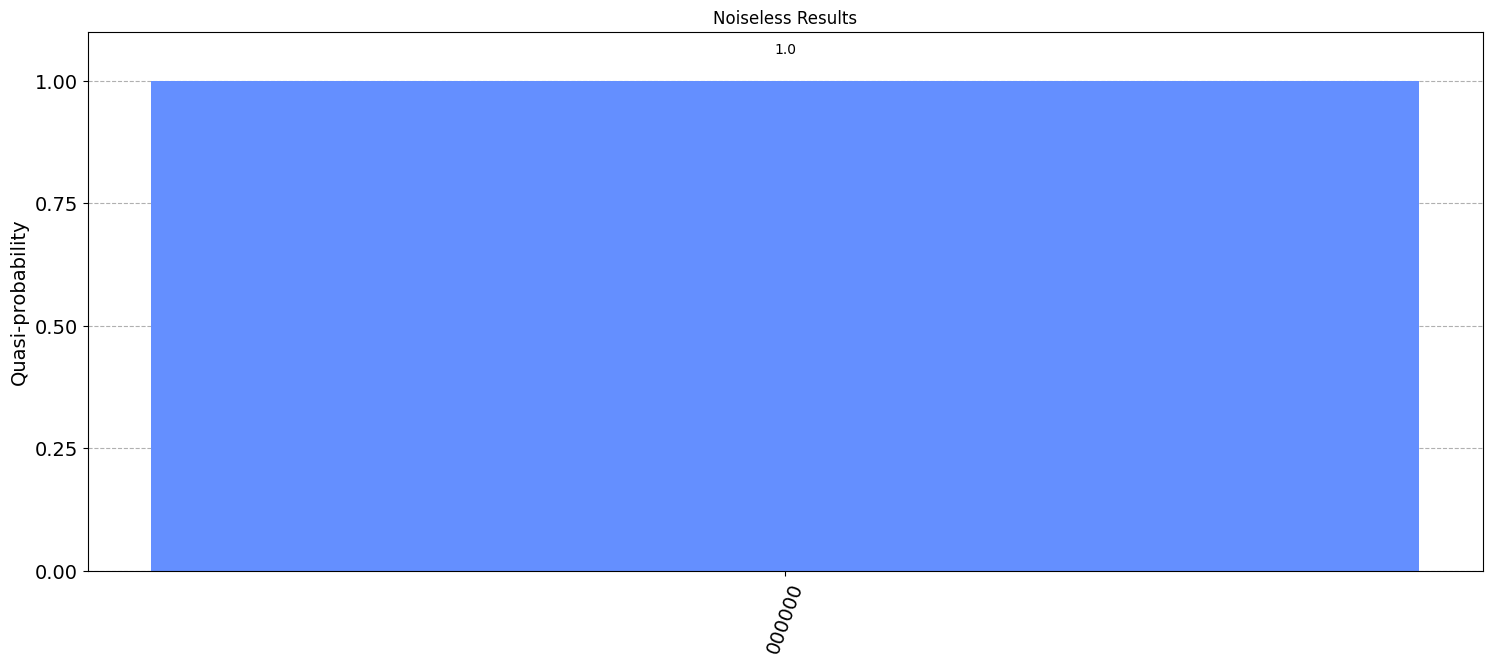

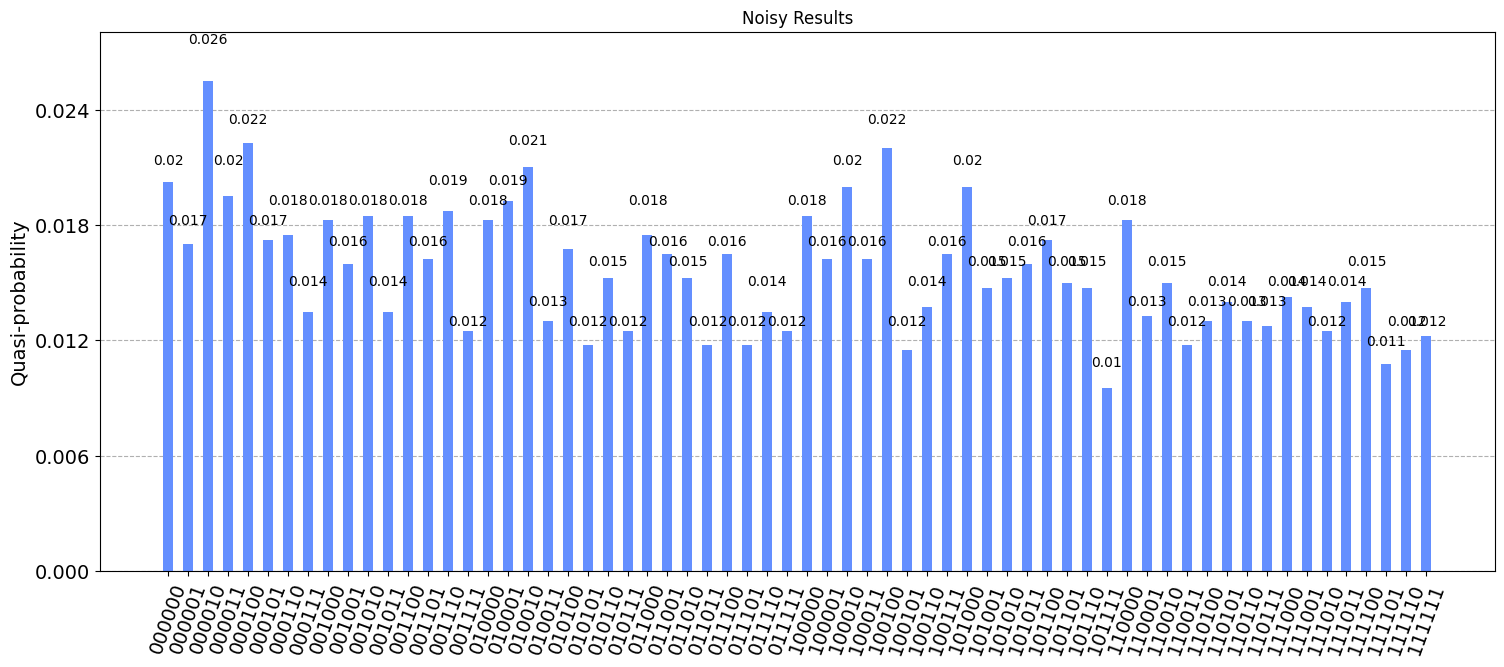

cost: 12.80425 



In [303]:
num_iterations = 4
num_qubits = 6
depol_noise_prob = 0.15
                
unm = Unified_Noise_Model()
unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])

cost = cost_func_random(num_qubits,num_iterations,unm.noise_model) 
print('cost:',cost,'\n')

In [304]:
def multiple_minimizations(repetitions, num_qubits,num_iterations, depol_noise_prob):

    #noise model
    unm = Unified_Noise_Model()
    unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])
    #print(unm.noise_model)
    scores = []
    params = []

    for repetition in range(repetitions):
        param = []
        #costs = []
        for i in range(num_iterations):            
            param.append( np.random.uniform(0, 1) * pi)
            param.append( np.random.uniform(0, 1)* pi)
            param.append( np.random.uniform(0, 1)* pi)
            param.append( np.random.uniform(0, 1) * pi)
        
        result = minimize(
            fun=func,
            x0=param,
            args=[num_qubits,num_iterations,unm.noise_model],
            method='COBYLA',
            tol=1e-7,
            options={"maxiter": 85000}
        )
        #plt.plot(range(len(costs)),costs, label='Cost Function')
        #plt.xlabel('optimization step')
        #plt.ylabel('cost')
        
        scores.append(result.fun)
        params.append(result.x)
        
    optimal_parameters = params[np.argmin(scores)]
    
    #cost = func(result.x,[num_qubits,num_iterations,unm.noise_model])
    
    return optimal_parameters, scores, params

In [305]:
optimal_parameters, scores, params =  multiple_minimizations(15, num_qubits,num_iterations, depol_noise_prob)

In [306]:
scores

[12.825,
 12.76725,
 12.7685,
 12.78925,
 12.7805,
 12.75125,
 12.78025,
 12.771,
 12.7975,
 12.7665,
 12.80625,
 12.74525,
 12.76575,
 12.794,
 12.8385]

In [307]:
optimal_parameters

array([1.61746428, 2.76108537, 2.26134508, 2.86804033, 0.07308728,
       2.64070586, 0.7633885 , 2.21709437, 1.75973506, 2.35186867,
       1.70429488, 0.90359604, 1.03458836, 0.32151202, 0.59977065,
       2.43544184])

/home/onofre/anaconda3/envs/noise_native_gates/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


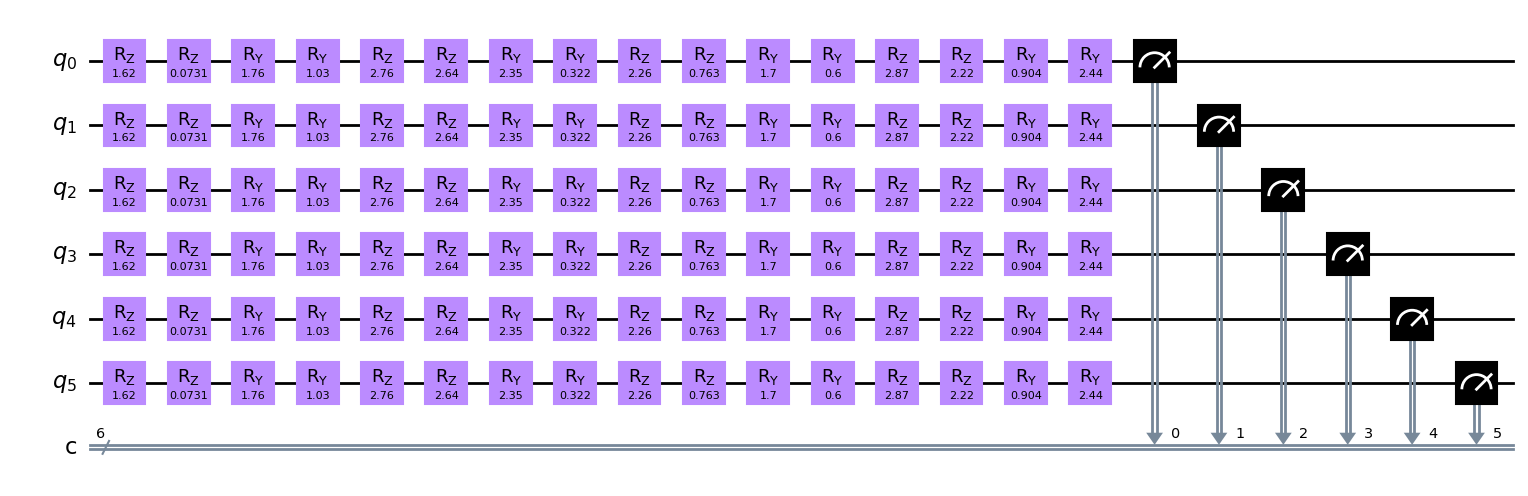

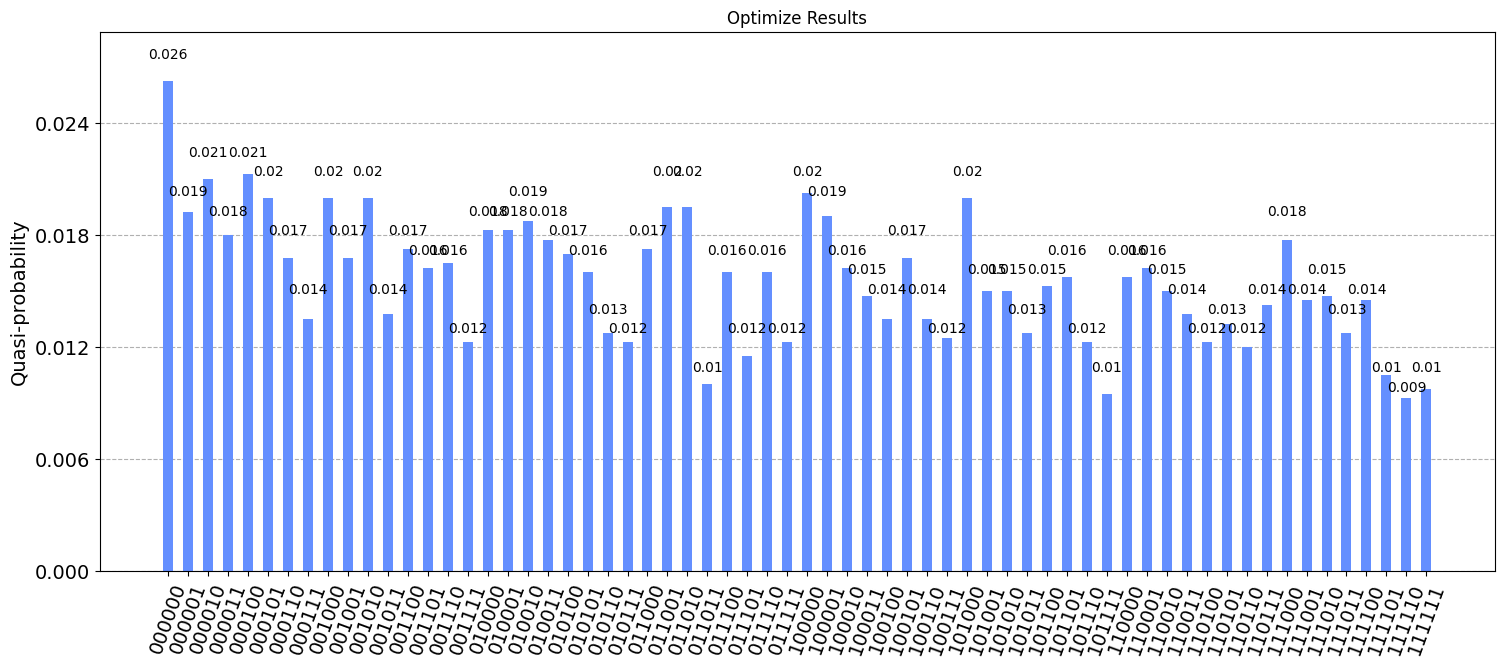

12.781
cost: 12.781 



In [308]:
unm = Unified_Noise_Model()

unm.add_depolarizing_channel(depol_noise_prob,['rz', 'ry'],[])

cost = cost_func_test_param(optimal_parameters,num_qubits,num_iterations,unm.noise_model) 
print('cost:',cost,'\n')


* Second, try varying the depolarizing noise level and compare the minimized parameters.
